# Experiments with MNIST Dataset and Original MoE

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.
5. original MoE with $L_{importance}$ regularization with 10 and 15 experts.
6. original MoE with $L_s$ regularization with 10 and 15 experts.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best performance
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models, figures and results will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) #mean and standard deviation computed from the dataset

In [8]:
# Complete train and test data
trainsize = 60000
testsize = 10000

In [9]:
batch_size = 512

In [10]:
# Load data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


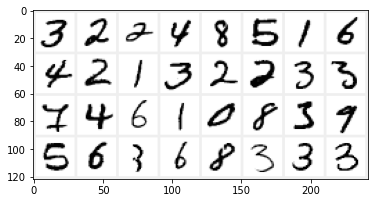

In [11]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [13]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1) # The temperature parameter is 1 for all the experiments
        return t


In [14]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [15]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation. The single model has the same
# architecture as an expert
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

## Initialize configurations and helper functions

In [16]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train original model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [17]:
def train_original_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                         w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20):

    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, 
                                                                                      w_sample_sim_same_range,  
                                                                                      w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
 
        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)

                gate_model = gate_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe, T = T, 
                                       w_importance=w_importance, w_sample_sim_same = w_sample_sim_same, 
                                       w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            if  os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []


### Function to train the single model

In [18]:
def train_single_model(model_name, trainloader, testloader, num_classes, num_epochs, runs):
    
    loss_criterion = cross_entropy_loss()
    
    n_runs = {'models':[], 'history':[]}
    
    for run in range(1, runs+1):
        
        print('Run', run)
        
        model = single_model(num_classes).to(device)
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=False)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                optimizer.zero_grad()
                loss = loss_criterion(outputs, None, None, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = model(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            test_running_accuracy = 0.0
            test_num_batches = 0
            
            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)
                test_outputs = model(test_inputs)              
                test_running_accuracy += accuracy(test_outputs, test_labels)
                test_num_batches += 1
                
            loss = (running_loss/num_batches)
            train_accuracy = (train_running_accuracy/num_batches)
            test_accuracy = (test_running_accuracy/test_num_batches)
            
            history['loss'].append(loss)
            history['accuracy'].append(train_accuracy.item())
            history['val_accuracy'].append(test_accuracy.item())
            
            print('epoch %d' % epoch,
                  'training loss %.2f' % loss,
                   ', training accuracy %.2f' % train_accuracy,
                   ', test accuracy %.2f' % test_accuracy
                   )
        
        # Save all the trained models
        plot_file = generate_plot_file(model_name, specific=str(num_classes)+'_models.pt')
        if  os.path.exists(os.path.join(model_path, plot_file)):
            n_runs = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        n_runs['models'].append(model)
        n_runs['history'].append(history)        
        torch.save(n_runs, open(os.path.join(model_path, plot_file),'wb'))
        
        n_runs = {'models':[], 'history':[]}

## Experiments

### Experiment 1: Original MoE model trained without gate regularization

In [71]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_hidden_32'

In [72]:
total_experts = 5

In [73]:
num_epochs = 20

In [74]:
runs = 1

In [75]:
train_oginal_model(model_1, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.26 , training accuracy 0.65 , test accuracy 0.87
epoch 1 training loss 0.37 , training accuracy 0.89 , test accuracy 0.91
epoch 2 training loss 0.29 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.26 , training accuracy 0.92 , test accuracy 0.93
epoch 4 training loss 0.24 , training accuracy 0.93 , test accuracy 0.93
epoch 5 training loss 0.22 , training accuracy 0.93 , test accuracy 0.94
epoch 6 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 7 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 8 training loss 0.19 , training accuracy 0.94 , test accuracy 0.94
epoch 9 training loss 0.18 , training accuracy 0.95 , test accuracy 0.95
epoch 10 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 11 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 12 training loss 0.15 , training accuracy 0.96 ,

### Experiment 2: Original MoE model trained with $L_{importance}$ regularization

In [91]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_reg_hidden_32'

In [92]:
total_experts = 5

In [98]:
num_epochs = 20

In [122]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [115]:
runs = 10

In [101]:
train_original_model(model_2, trainloader, testloader, runs, w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

w_importance 1.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.64 , training accuracy 0.55 , test accuracy 0.85
epoch 1 training loss 0.45 , training accuracy 0.88 , test accuracy 0.91
epoch 2 training loss 0.30 , training accuracy 0.92 , test accuracy 0.93
epoch 3 training loss 0.24 , training accuracy 0.93 , test accuracy 0.94
epoch 4 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.19 , training accuracy 0.95 , test accuracy 0.95
epoch 6 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 8 training loss 0.15 , training accuracy 0.96 , test accuracy 0.96
epoch 9 training loss 0.14 , training accuracy 0.96 , test accuracy 0.96
epoch 10 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 11 training loss 0.13 , training accuracy 0.97 , test accuracy 0.96
epoch 12 training loss 0.12 , training accuracy 0.97 ,

### Experiment 3: Original MoE model trained with sample similarity regularization, $L_s$

In [103]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_with_reg_hidden_32'

In [104]:
total_experts = 5

In [105]:
num_epochs = 20

In [116]:
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-06, 1e-05]
w_sample_sim_diff_range =  [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [117]:
runs = 10

In [108]:
train_original_model(model_3, trainloader, testloader, runs, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 0.1
Run: 1
epoch 0 training loss 1.72 , training accuracy 0.58 , test accuracy 0.86
epoch 1 training loss 0.63 , training accuracy 0.89 , test accuracy 0.90
epoch 2 training loss 0.51 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.45 , training accuracy 0.93 , test accuracy 0.93
epoch 4 training loss 0.42 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.40 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 0.38 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.35 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.34 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.33 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.32 , training accuracy 0.96 , test accuracy 0.96
epoch 12 training loss 0.32 , training accuracy 0.96

### Experiment 4: Training the single model

In [109]:
model_4 = 'mnist_single_model_hidden_32'

In [110]:
num_epochs = 20

In [118]:
runs = 10

In [112]:
train_single_model(model_4, trainloader, testloader, num_classes, num_epochs, runs)

Run 1
epoch 0 training loss 1.63 , training accuracy 0.45 , test accuracy 0.71
epoch 1 training loss 0.65 , training accuracy 0.79 , test accuracy 0.83
epoch 2 training loss 0.50 , training accuracy 0.84 , test accuracy 0.85
epoch 3 training loss 0.46 , training accuracy 0.86 , test accuracy 0.87
epoch 4 training loss 0.42 , training accuracy 0.87 , test accuracy 0.88
epoch 5 training loss 0.40 , training accuracy 0.87 , test accuracy 0.88
epoch 6 training loss 0.39 , training accuracy 0.88 , test accuracy 0.88
epoch 7 training loss 0.37 , training accuracy 0.89 , test accuracy 0.89
epoch 8 training loss 0.37 , training accuracy 0.89 , test accuracy 0.89
epoch 9 training loss 0.36 , training accuracy 0.89 , test accuracy 0.89
epoch 10 training loss 0.35 , training accuracy 0.89 , test accuracy 0.90
epoch 11 training loss 0.35 , training accuracy 0.89 , test accuracy 0.90
epoch 12 training loss 0.34 , training accuracy 0.90 , test accuracy 0.90
epoch 13 training loss 0.33 , training acc

### Experiment 5: Original MoE with $L_{importance}$ regularization with:

#### 10 Experts

In [21]:
# Model with gate and expert parameters initialized to default values
model_5_10 = 'mnist_with_reg'

In [22]:
total_experts = 10

In [23]:
num_epochs = 20

In [24]:
w_importance_range = [1.0]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['1.0']


In [25]:
runs = 1

In [26]:
train_original_model(model_5_10, trainloader, testloader, runs, w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

w_importance 1.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.70 , training accuracy 0.60 , test accuracy 0.84
epoch 1 training loss 0.53 , training accuracy 0.87 , test accuracy 0.90
epoch 2 training loss 0.34 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.29 , training accuracy 0.92 , test accuracy 0.93
epoch 4 training loss 0.25 , training accuracy 0.93 , test accuracy 0.93
epoch 5 training loss 0.24 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 0.22 , training accuracy 0.94 , test accuracy 0.94
epoch 7 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 8 training loss 0.20 , training accuracy 0.95 , test accuracy 0.94
epoch 9 training loss 0.19 , training accuracy 0.95 , test accuracy 0.94
epoch 10 training loss 0.18 , training accuracy 0.95 , test accuracy 0.95
epoch 11 training loss 0.18 , training accuracy 0.95 , test accuracy 0.95
epoch 12 training loss 0.17 , training accuracy 0.95 ,

#### 15 Experts

In [25]:
# Model with gate and expert parameters initialized to default values
model_5_15 = 'mnist_with_reg'

In [26]:
total_experts = 15

In [27]:
num_epochs = 10

In [28]:
w_importance_range = [1.0]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['1.0']


In [29]:
runs = 1

In [ ]:
train_original_model(model_5_15, trainloader, testloader, runs, w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

### Experiment 6: Original MoE model trained with sample similarity regularization, $L_s$ with:

#### 10 Experts

In [27]:
# Model with gate and expert parameters initialized to default values
model_6_10 = 'mnist_with_reg'

In [104]:
total_experts = 10

In [105]:
num_epochs = 20

In [28]:
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-06]
w_sample_sim_diff_range =  [0.1]


In [117]:
runs = 1

In [108]:
train_original_model(model_6_10, trainloader, testloader, runs, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 0.1
Run: 1
epoch 0 training loss 1.72 , training accuracy 0.58 , test accuracy 0.86
epoch 1 training loss 0.63 , training accuracy 0.89 , test accuracy 0.90
epoch 2 training loss 0.51 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.45 , training accuracy 0.93 , test accuracy 0.93
epoch 4 training loss 0.42 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.40 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 0.38 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.35 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.34 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.33 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.32 , training accuracy 0.96 , test accuracy 0.96
epoch 12 training loss 0.32 , training accuracy 0.96

#### 15 Experts

In [ ]:
# Model with gate and expert parameters initialized to default values
model_6_15 = 'mnist_with_reg'

In [104]:
total_experts = 15

In [105]:
num_epochs = 20

In [ ]:
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

In [117]:
runs = 1

In [108]:
train_original_model(model_6_15, trainloader, testloader, runs, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 0.1
Run: 1
epoch 0 training loss 1.72 , training accuracy 0.58 , test accuracy 0.86
epoch 1 training loss 0.63 , training accuracy 0.89 , test accuracy 0.90
epoch 2 training loss 0.51 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.45 , training accuracy 0.93 , test accuracy 0.93
epoch 4 training loss 0.42 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.40 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 0.38 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.35 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.34 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.33 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.32 , training accuracy 0.96 , test accuracy 0.96
epoch 12 training loss 0.32 , training accuracy 0.96

## Results

### Collect the train error, test error for the trained single models and store in the '../results/mnist_results.csv' file.

In [121]:
import csv

m = 'mnist_single_model_hidden_32'
plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')

# loading model from pre_trained_model_path. Change this to model_path to use models you train
models = torch.load(open(os.path.join(pre_trained_model_path,'mnist', plot_file),'rb'), map_location=device)

filename = os.path.join(results_path, 'mnist_results.csv')

if os.path.exists(filename):
    p = 'a'
else:
    p = 'w'
        
header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'expert usage']
    
with open(filename, p) as f:
    writer = csv.writer(f)        

    if p == 'w':            
        writer.writerow(header)
    for i, model in enumerate(models['models']):
        data = ['']*5
        data[0] = m+'_'+str(i)
        running_test_accuracy = 0.0
        num_batches = 0
        train_error = 1-models['history'][i]['accuracy'][-1]
        data[1] = train_error
        for test_inputs, test_labels in testloader:
            test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
            outputs = model(test_inputs)
            running_test_accuracy += accuracy(outputs, test_labels)
            num_batches += 1
        test_error = 1-(running_test_accuracy/num_batches)
        data[2] = test_error.item()
        
        writer.writerow(data)


### Plot the expert selection table of the MoE model trained with $L_{importance}$ and 10 experts

Model: mnist_with_reg_importance_1.0_10_10_models.pt

Experts used by the gate for classification of each digit


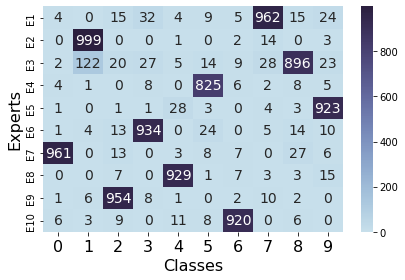

In [20]:
import seaborn as sns

model_1 = 'mnist_with_reg'

m = model_1
n_runs = 5
n_run = 1
total_experts = 10
plot_file = generate_plot_file(m, w_importance=1.0, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'mnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[4]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d',annot_kws={"size": 14}, ax=ax1)
        ax1.set_xlabel('Classes', fontsize=16)
        ax1.set_ylabel('Experts',fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Plot the expert selection table of the MoE model trained with $L_{importance}$ and 15 experts

Model: mnist_with_reg_importance_1.0_10_15_models.pt

Experts used by the gate for classification of each digit


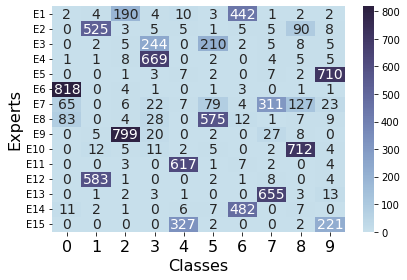

In [21]:
import seaborn as sns

model_1 = 'mnist_with_reg'

m = model_1
n_runs = 5
n_run = 1
total_experts = 15
plot_file = generate_plot_file(m, w_importance=1.0, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'mnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[4]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d',annot_kws={"size": 14}, ax=ax1)
        ax1.set_xlabel('Classes', fontsize=16)
        ax1.set_ylabel('Experts',fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Plot the expert selection table of the MoE model trained with $L_s$ and 10 experts

Model: mnist_with_reg_sample_sim_same_1e-05_sample_sim_diff_0.0001_10_10_models.pt

Experts used by the gate for classification of each digit


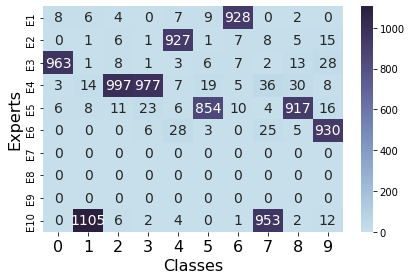

In [22]:
import seaborn as sns

model_1 = 'mnist_with_reg'

m = model_1
n_runs = 5
n_run = 1
total_experts = 10
w_sample_sim_same = 1e-5
w_sample_sim_diff = 1e-4
plot_file = generate_plot_file(m, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff,
                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'mnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[4]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d',annot_kws={"size": 14}, ax=ax1)
        ax1.set_xlabel('Classes', fontsize=16)
        ax1.set_ylabel('Experts',fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Plot the expert selection table of the MoE model trained with $L_s$ and 15 experts

Model: mnist_with_reg_sample_sim_same_1e-05_sample_sim_diff_0.0001_10_15_models.pt

Experts used by the gate for classification of each digit


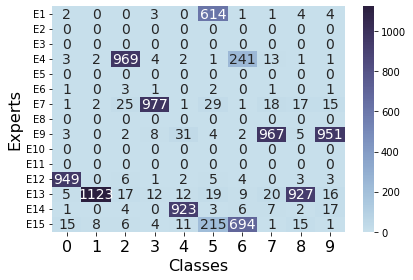

In [23]:
import seaborn as sns

model_1 = 'mnist_with_reg'

m = model_1
n_runs = 5
n_run = 1
total_experts = 15
w_sample_sim_same = 1e-5
w_sample_sim_diff = 1e-4
plot_file = generate_plot_file(m, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff,
                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'mnist', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[0]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d',annot_kws={"size": 14}, ax=ax1)
        ax1.set_xlabel('Classes', fontsize=16)
        ax1.set_ylabel('Experts',fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()